In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
%matplotlib inline

class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid, labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds','cluster']
        merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text','helpful']]
        return merged_lite

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))
    
    def onlysize(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster: ', i)
            print('cluster size: ', cluster.shape)
            
    def wordcloud(self, n_samples):
        merged = self.merge_labels()
        list_of_words_str = ' '.join(merged)
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            cluster = list_of_words_str.loc[list_of_words_str['cluster'] == i]
            wc = WordCloud(background_color="white", max_words=len(merged),width=1080, height=720,min_font_size = 10, collocations=False)
            wc.generate(cluster)
            plt.figure(figsize=(10,10))
            print ("\n\nWord Cloud for Important features")
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stephaniedang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
raw_data = pd.read_json('food_enforcement_US_bacteria.json', orient='records')

In [3]:
print(raw_data.shape)
print(raw_data.head(10).product_description)

(6104, 26)
0    Native Catch Salmon Bacon, Traditional flavor....
1    Delish Fruit Burst 10 oz.(283 g)  Enjoy by: 8/...
2    Garden Pure Holiday Fruit Bowl 4 lbs (1.81kg) ...
3    Fresh Fruit Product is labeled in part:  "***F...
4    Ready Pac¿ Gourmet Fruit Bowl, 64oz , UPC 7774...
5    River Ranch brand Diced Grn Cabbage w/Color, 4...
6    Sweet and Sour Stir Fry packaged under the fol...
7    Onion Slab Cut.  Products are labeled in part:...
8    MIX w/yellow onions used as an ingredient.  Pr...
9    Fresh n Easy brand Shred Grn Cabbage w/Color, ...
Name: product_description, dtype: object


### Bag of words feature representation for descriptive text

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_df=0.9, strip_accents='ascii')

corpus = []
raw_data['product_description'] = raw_data['product_description'].str.replace('[^\w\s]','')
#print(raw_data['product_description'].head(10))

for i in range(0,len(raw_data['product_description'])):
    text=raw_data.product_description[i].lower()
    list = text[:100]

    corpus += [list]
    
#print(corpus)
X = vectorizer.fit_transform(corpus)
X.shape

/var/folders/z9/3j8g48c52lq3yy76h7m23vnm0000gn/T/ipykernel_49139/781615669.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  raw_data['product_description'] = raw_data['product_description'].str.replace('[^\w\s]','')


(6104, 9827)

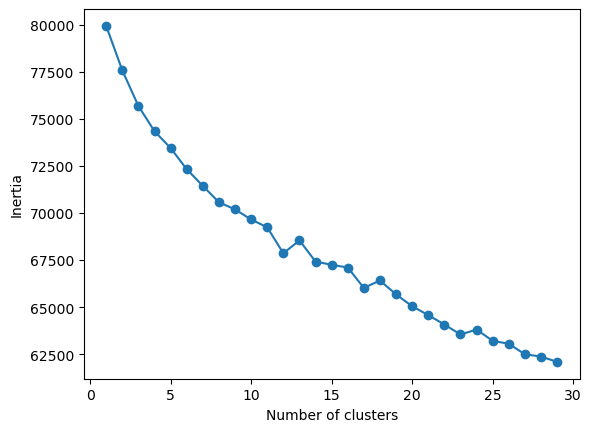

In [5]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# # fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(1, 30):
    km = KMeans(n_clusters=i)
    km.fit(X)
    distortions.append(km.inertia_)

len(distortions)
    
# vizualize change inx inertia
plt.plot(range(1, 30), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

### fit Kmeans

In [6]:
#fit Kmeans with k clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=50,n_init=30)
km.fit(X)

KMeans(n_clusters=50, n_init=30)

### labels are named with integers and stored in the `labels_` attribute

In [7]:
km.labels_

array([16, 17, 17, ..., 17, 47, 47], dtype=int32)

### take a look at one of the cluster results

In [8]:
# You should look at all the clusters, but let's look at cluster "15" (I chose this arbitrarily; you should look at all of them)

# for i in range(0,len(km.labels_)):
#     if km.labels_[i] == 15:
#         print(raw_data['product_description'][i])
#         print('**********')

clusterVal = 15
sampleLen = 5
for x in range(0,clusterVal):
    count = 0
    sample = []
    
    for i in range(0,len(km.labels_)):
        if km.labels_[i] == x:
            count += 1
            if count < sampleLen:
                sample.append(raw_data['product_description'][i])
    
    print('**********')
    print('Cluster ' + str(x))
    print('Count ' + str(count))
    print('Sample of ' + str(sampleLen) + ' Descriptions\n')
    for i in range(0,len(sample)):
        print(sample[i] + '\n')
        
        

**********
Cluster 0
Count 50
Sample of 5 Descriptions

Onion Slab Cut  Products are labeled in part  Onions Yellow SlabReady To Eat ProductLB         FP CENTRAL FL FRESHCUTS ONIONS FC YELLOW SLABRT  FC    Item  514064 ONIONS FC YELLOW SLAB 116 25  Item  514058 ONIONS FC YELLOW SLAB 14 45   Item  514034 ONIONS FC YELLOW SLAB 38 NO 45  Item  481155 ONIONS FC YELLOW SLAB CUT 18 25          

Onions Julienne Sliced  Products are labeled in part  Onions Yellow Julienne SlicedReady To Eat Product45 LB         FP CENTRAL FL FRESHCUTS ONIONS FC YELLOW JUL SLICED 1445 RT  FC    Item   514098 ONIONS FC YELLOW JUL SLICED 14  45                       

14 Diced Red Onions 5 LB Bag

Yellow Onion  Product is labeled in part  Onion Yellow JulienneORBOrthodox Rabbinical Board of Broward and Palm Beach CountiesRefrigerate at 34 F      FC Onion Yellow JulienneORBOrthodox Rabbinical Board of Broward and Palm Beach CountiesRefrigerate at 34 F        Item  301570 FC ONION YELLOW JULIENNE 38 25    Item  30

In [9]:
# create an instance of ViewClusteringResults to view results of final KMeans fit

viz = ViewClusteringResults(X, km)

In [10]:
# modify this list to include the numbers of clusters you want to see
# I have *arbitrarily* chosen these values
range_n_clusters = [5, 10, 15, 20, 25]

For n_clusters = 5 The average silhouette_score is : 0.023433299647925468


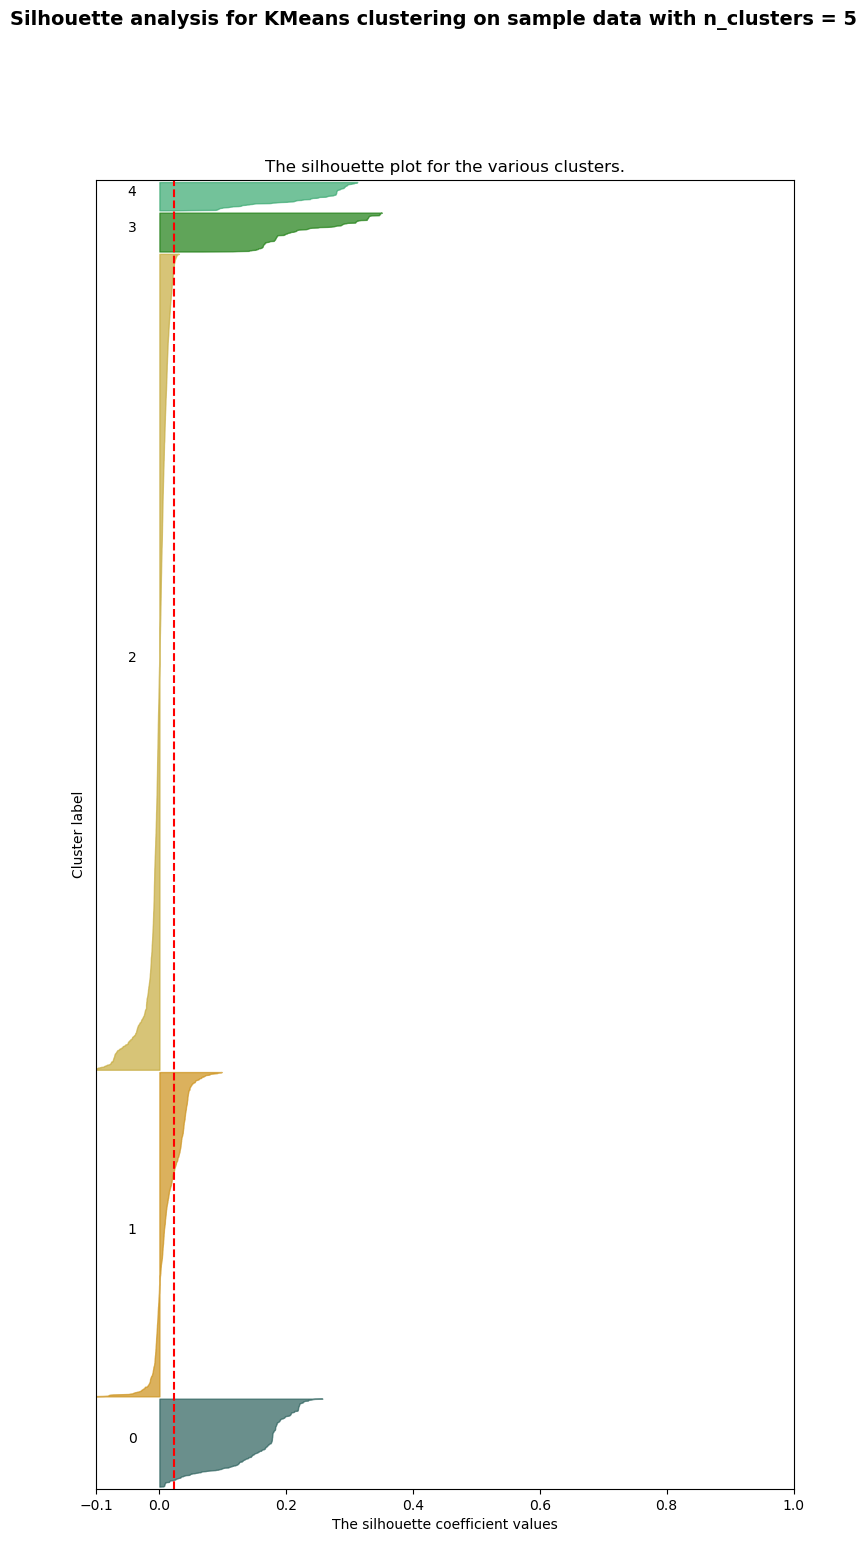

For n_clusters = 10 The average silhouette_score is : 0.04972439433685325


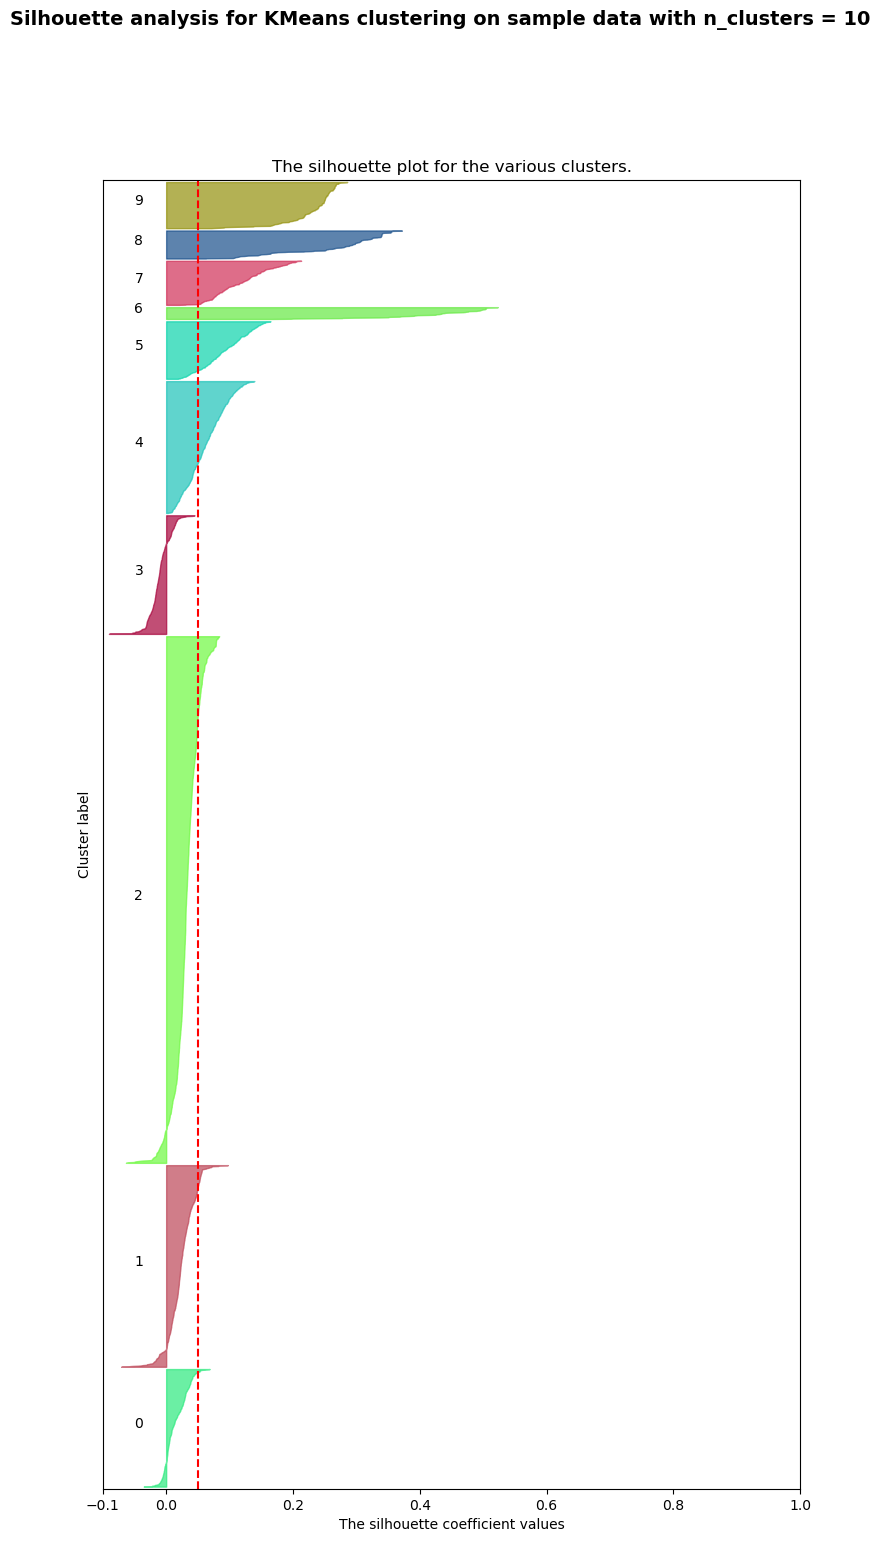

For n_clusters = 15 The average silhouette_score is : 0.032635280302366974


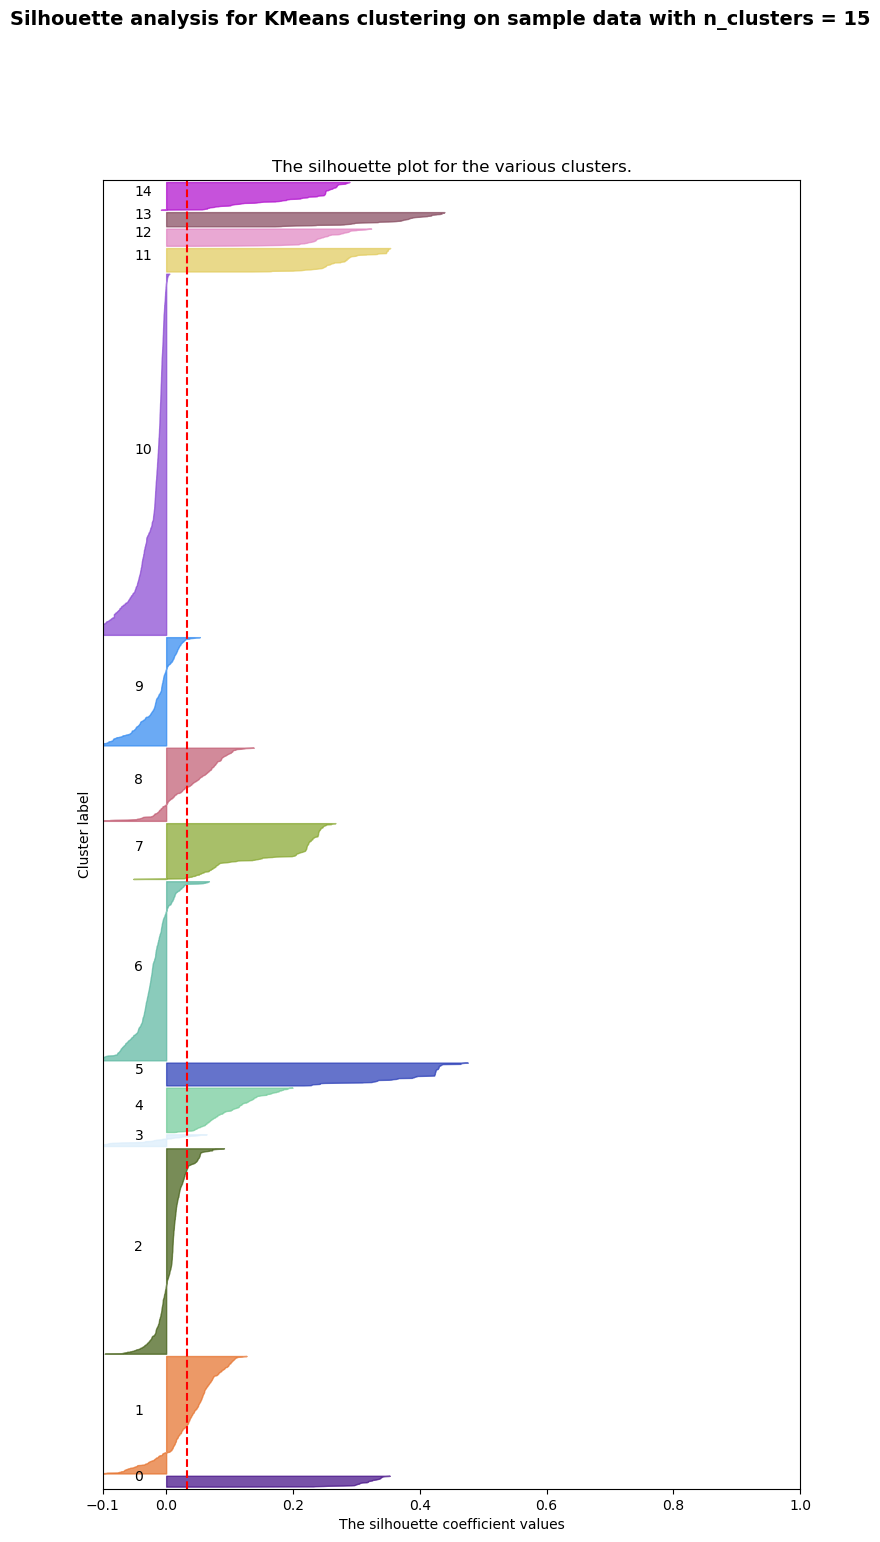

For n_clusters = 20 The average silhouette_score is : 0.04528217210997181


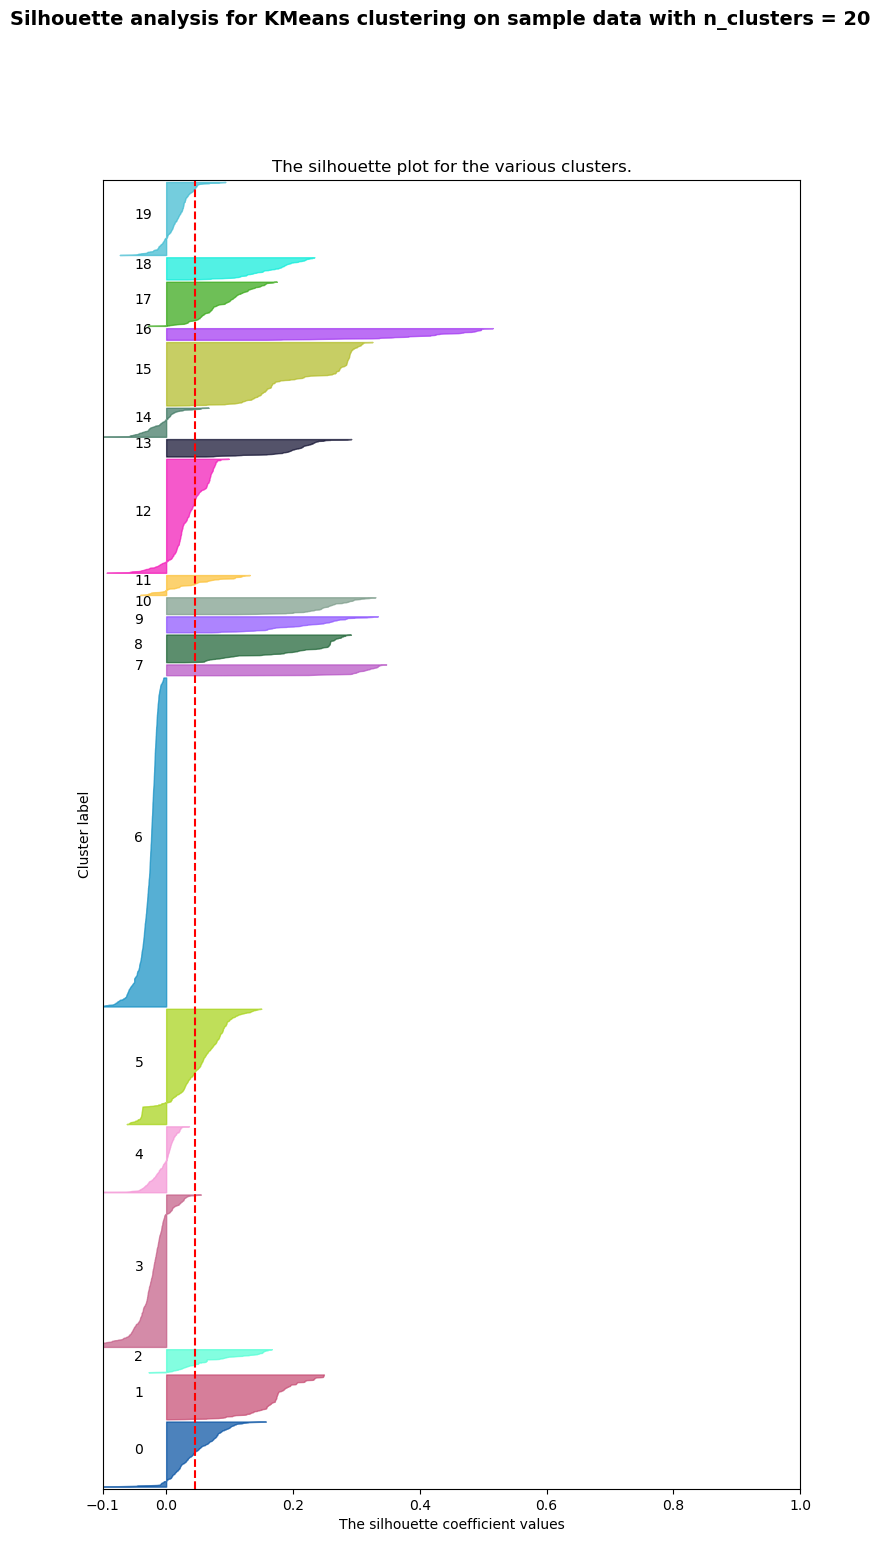

For n_clusters = 25 The average silhouette_score is : 0.05334217477873661


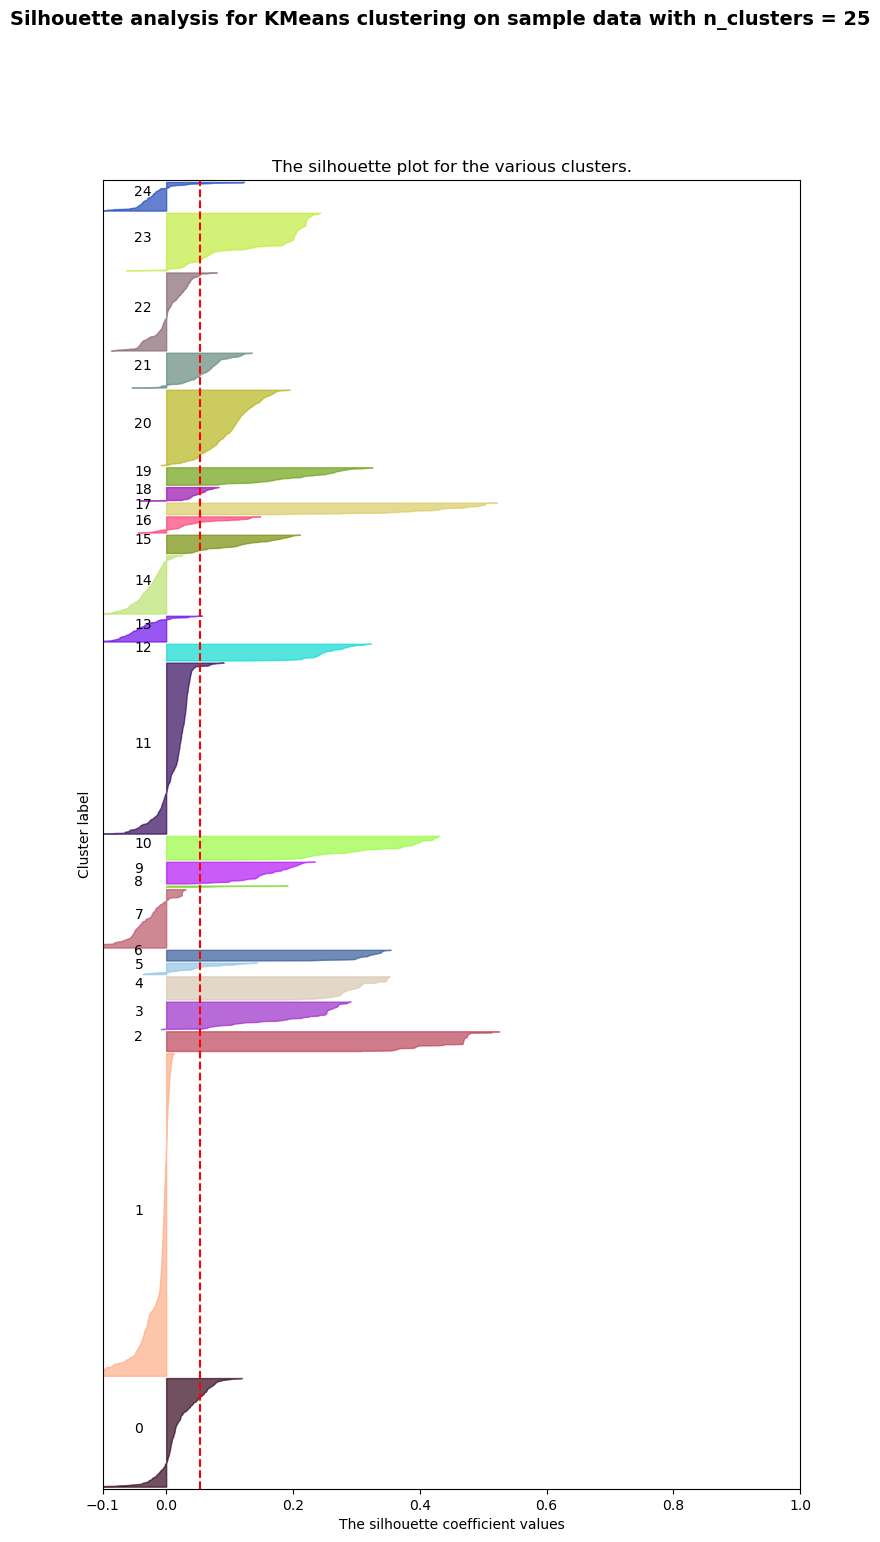

In [11]:
# modified from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import random

for n_clusters in range_n_clusters:
    # Create a subplot
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(9, 17)

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    # ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    ax1.set_ylim([0, len(km.labels_) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # select a random color for this cluster
        r = lambda: random.randint(0,255)
        color = '#%02X%02X%02X' % (r(),r(),r())
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()